In [1]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, ConfusionMatrixDisplay, accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import CamembertTokenizer, CamembertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1080'

In [3]:
# Load the data
train_df = pd.read_csv("../data/train.csv")
train_df = train_df.set_index("id")
train_df.entities = train_df.entities.apply(json.loads)  # Parse entities
train_df.relations = train_df.relations.apply(json.loads)  # Parse relations

# Display the first few rows
train_df.head()

,text,entities,relations
id,,,
181,"Anam Destresse, président de l'ONG ""Ma passion...","[{'id': 0, 'mentions': [{'value': 'accident', ...","[[0, STARTED_IN, 9], [7, IS_LOCATED_IN, 9], [5..."
31669,"À Paris, le 8 avril 2022, l'usine de déodorant...","[{'id': 0, 'mentions': [{'value': 'explosé', '...","[[9, IS_LOCATED_IN, 8], [11, OPERATES_IN, 8], ..."
51470,"En Espagne, dans une région agricole, une cont...","[{'id': 0, 'mentions': [{'value': 'contaminati...","[[7, IS_PART_OF, 8], [9, OPERATES_IN, 1], [0, ..."
51332,Un important incendie a fait des ravages dans ...,"[{'id': 0, 'mentions': [{'value': 'incendie', ...","[[12, IS_IN_CONTACT_WITH, 5], [0, IS_LOCATED_I..."
1131,« Je coule » : onze heures après avoir envoyé ...,"[{'id': 0, 'mentions': [{'value': 'renversé', ...","[[9, IS_LOCATED_IN, 2], [0, START_DATE, 17], [..."


In [4]:
# 1. Get top 10 relation labels
all_relations = [rel[1] for row in train_df['relations'] for rel in row]
top_10_relations = [rel for rel, _ in Counter(all_relations).most_common(10)]
top_10_relations

['IS_LOCATED_IN',
 'HAS_CONTROL_OVER',
 'IS_IN_CONTACT_WITH',
 'OPERATES_IN',
 'STARTED_IN',
 'IS_AT_ODDS_WITH',
 'IS_PART_OF',
 'START_DATE',
 'GENDER_MALE',
 'HAS_CATEGORY']

In [5]:
len(top_10_relations)

10

In [6]:
# 3. Encode labels
le = LabelEncoder()
df_processed = pd.DataFrame()
df_processed['label'] = le.fit_transform(top_10_relations)

# 1 - Preprocess

In [ ]:
def prepare_dataset(df, relation_types, max_seq_length=300, context_margin=25):
    tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
    data = []
    
    for _, row in df.iterrows():
        text = row["text"]
        entities = {e["id"]: e for e in row["entities"]}
        
        for rel in row["relations"]:
            e1_id, rel_type, e2_id = rel
            if rel_type not in relation_types:
                continue

            # Find best mention pair (closest in text)
            best_pair = find_closest_mentions(
                entities[e1_id]["mentions"], 
                entities[e2_id]["mentions"]
            )
            
            if not best_pair:
                continue

            # Extract focused text window
            window_text, e1_pos, e2_pos = create_entity_window(
                text, 
                best_pair[0], 
                best_pair[1], 
                context_margin
            )
            
            # Mark only the target entities
            marked_text = (
                window_text[:e1_pos[0]] + 
                f"[E{e1_id}]{best_pair[0]['value']}[/E{e1_id}]" +
                window_text[e1_pos[1]:e2_pos[0]] + 
                f"[E{e2_id}]{best_pair[1]['value']}[/E{e2_id}]" +
                window_text[e2_pos[1]:]
            )
            
            # Tokenize with length control
            inputs = tokenizer(
                marked_text,
                max_length=max_seq_length,
                truncation=True,
                padding="max_length"
            )
            
            data.append({
                "text": tokenizer.decode(inputs["input_ids"], skip_special_tokens=True),
                "label": relation_types.index(rel_type)
            })
            
    return data

def find_closest_mentions(mentions1, mentions2):
    """Find closest mention pair between two entities"""
    min_distance = float('inf')
    best_pair = None
    
    for m1 in mentions1:
        for m2 in mentions2:
            distance = abs(m1["start"] - m2["start"])
            if distance < min_distance:
                min_distance = distance
                best_pair = (m1, m2)
    
    return best_pair

def create_entity_window(text, mention1, mention2, margin):
    """Create text window containing both mentions with context margin"""
    start = min(mention1["start"], mention2["start"]) - margin
    end = max(mention1["end"], mention2["end"]) + margin
    
    # Adjust window boundaries
    start = max(0, start)
    end = min(len(text), end)
    
    # Calculate relative positions
    window_text = text[start:end]
    return (
        window_text,
        (mention1["start"] - start, mention1["end"] - start),
        (mention2["start"] - start, mention2["end"] - start)
    )

dataset = prepare_dataset(train_df, top_10_relations)
train_data, val_data = train_test_split(dataset, test_size=0.1, random_state=42)

In [ ]:
train_data[0]

{'text': 'arrivée sur place et les [E12]secouristes[/E12] ont déposé la [E6]victime[/E6] sur une civière. Après l',
 'label': 2}

In [ ]:
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

# Custom Dataset Class
class RelationDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=300):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        encoding = self.tokenizer(
            item["text"],
            truncation=True,
            max_length=self.max_length,
            return_attention_mask=True,
        )
        return {
            "input_ids": encoding["input_ids"],
            "attention_mask": encoding["attention_mask"],
            "labels": item["label"],
        }

train_dataset = RelationDataset(train_data, tokenizer)
val_dataset = RelationDataset(val_data, tokenizer)

In [11]:
# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 2 - Train

In [ ]:
model = CamembertForSequenceClassification.from_pretrained("camembert-base",num_labels=len(top_10_relations))

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    
    accuracy = accuracy_score(labels, predictions)
    
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(labels, predictions, average='macro', zero_division=0)
    
    precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(labels, predictions, average=None, zero_division=0)
    
    return {
        'accuracy': accuracy,
        'macro_f1': f1_macro,
        'macro_precision': precision_macro,
        'macro_recall': recall_macro,
        'precision_per_class': precision_per_class.tolist(),  # Per-class precision
        'recall_per_class': recall_per_class.tolist(),        # Per-class recall
        'f1_per_class': f1_per_class.tolist(),               # Per-class F1
    }

In [ ]:
training_args = TrainingArguments(
    output_dir="../saved_models/results",
    num_train_epochs=3,
    eval_strategy='steps',
    eval_steps=500, 
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    save_strategy="steps",
    metric_for_best_model='macro_f1',
    save_total_limit=2,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset, # Automatically shuffled
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall,Precision Per Class,Recall Per Class,F1 Per Class
500,1.898700,1.333761,0.597144,0.380798,0.365864,0.448140,"[0.5975692099932478, 0.898876404494382, 0.4540441176470588, 0.0, 0.0, 0.0, 0.0, 0.9814814814814815, 0.4488888888888889, 0.2777777777777778]","[0.9899328859060402, 0.5769230769230769, 0.7993527508090615, 0.0, 0.0, 0.0, 0.0, 1.0, 0.9901960784313726, 0.125]","[0.7452631578947368, 0.7027818448023426, 0.5791324736225087, 0.0, 0.0, 0.0, 0.0, 0.9906542056074766, 0.617737003058104, 0.1724137931034483]"
1000,1.024600,0.767188,0.732807,0.606406,0.624530,0.639667,"[0.7442455242966752, 0.9027777777777778, 0.49916805324459235, 0.8587360594795539, 0.0, 0.0, 0.5294117647058824, 1.0, 0.9456521739130435, 0.7653061224489796]","[0.9765100671140939, 0.625, 0.970873786407767, 0.9130434782608695, 0.0, 0.0, 0.12080536912751678, 1.0, 0.8529411764705882, 0.9375]","[0.8447024673439768, 0.7386363636363636, 0.6593406593406593, 0.8850574712643678, 0.0, 0.0, 0.19672131147540983, 1.0, 0.8969072164948454, 0.8426966292134831]"
1500,0.733200,0.617872,0.769635,0.704819,0.715958,0.711061,"[0.7530864197530864, 0.8885245901639345, 0.6515151515151515, 0.8695652173913043, 0.0, 0.631578947368421, 0.6213592233009708, 1.0, 0.8095238095238095, 0.9344262295081968]","[0.9552572706935123, 0.6514423076923077, 0.8349514563106796, 0.9486166007905138, 0.0, 0.5783132530120482, 0.42953020134228187, 1.0, 1.0, 0.7125]","[0.8422090729783037, 0.7517337031900139, 0.7319148936170212, 0.9073724007561437, 0.0, 0.6037735849056604, 0.5079365079365079, 1.0, 0.8947368421052632, 0.8085106382978723]"
2000,0.609200,0.566875,0.780158,0.741681,0.740755,0.754513,"[0.7461406518010292, 0.9487179487179487, 0.7212543554006968, 0.8618181818181818, 0.0, 0.6382978723404256, 0.55, 1.0, 0.9900990099009901, 0.9512195121951219]","[0.9731543624161074, 0.6225961538461539, 0.6699029126213593, 0.9367588932806324, 0.0, 0.7228915662650602, 0.6644295302013423, 1.0, 0.9803921568627451, 0.975]","[0.8446601941747572, 0.7518142235123367, 0.6946308724832215, 0.8977272727272727, 0.0, 0.6779661016949152, 0.601823708206687, 1.0, 0.9852216748768473, 0.9629629629629629]"
2500,0.536000,0.524079,0.781285,0.746313,0.736766,0.761511,"[0.7556357078449053, 0.8328267477203647, 0.7264150943396226, 0.8754716981132076, 0.0, 0.6403940886699507, 0.6041666666666666, 0.9906542056074766, 0.9902912621359223, 0.9518072289156626]","[0.9373601789709173, 0.6586538461538461, 0.7475728155339806, 0.9169960474308301, 0.0, 0.7831325301204819, 0.5838926174496645, 1.0, 1.0, 0.9875]","[0.836744882675986, 0.7355704697986577, 0.7368421052631579, 0.8957528957528957, 0.0, 0.7046070460704607, 0.5938566552901023, 0.9953051643192489, 0.9951219512195122, 0.9693251533742331]"
3000,0.513100,0.502328,0.784292,0.750214,0.741231,0.766104,"[0.7544483985765125, 0.8621794871794872, 0.7401315789473685, 0.8825757575757576, 0.0, 0.6363636363636364, 0.593939393939394, 1.0, 0.9902912621359223, 0.9523809523809523]","[0.9485458612975392, 0.6466346153846154, 0.7281553398058253, 0.9209486166007905, 0.0, 0.7590361445783133, 0.6577181208053692, 1.0, 1.0, 1.0]","[0.8404360753221011, 0.739010989010989, 0.734094616639478, 0.9013539651837524, 0.0, 0.6923076923076923, 0.6242038216560509, 1.0, 0.9951219512195122, 0.975609756097561]"
3500,0.453600,0.499770,0.787298,0.751958,0.742717,0.767341,"[0.7583108715184187, 0.827893175074184, 0.7797202797202797, 0.8700361010830325, 0.0, 0.6442307692307693, 0.581081081081081, 1.0, 0.9902912621359223, 0.975609756097561]","[0.9440715883668904, 0.6706730769230769, 0.7216828478964401, 0.9525691699604744, 0.0, 0.8072289156626506, 0.5771812080536913, 1.0, 1.0, 1.0]","[0.841056302939711, 0.7410358565737052, 0.7495798319327731, 0.909433962264151, 0.0, 0.7165775401069518, 0.5791245791245792, 1.0, 0.9951219512195122, 0.9876543209876543]"
4000,0.458700,0.499814,0.786922,0.750873,0.744021,0.766607,"[0.7539543057996485, 0.8673139158576052, 0.7678571428571429, 0.8782287822

TrainOutput(global_step=4491, training_loss=0.7420104287350743, metrics={'train_runtime': 3052.3433, 'train_samples_per_second': 23.538, 'train_steps_per_second': 1.471, 'total_flos': 8456543962795908.0, 'train_loss': 0.7420104287350743, 'epoch': 3.0})

# 3 - Evaluate

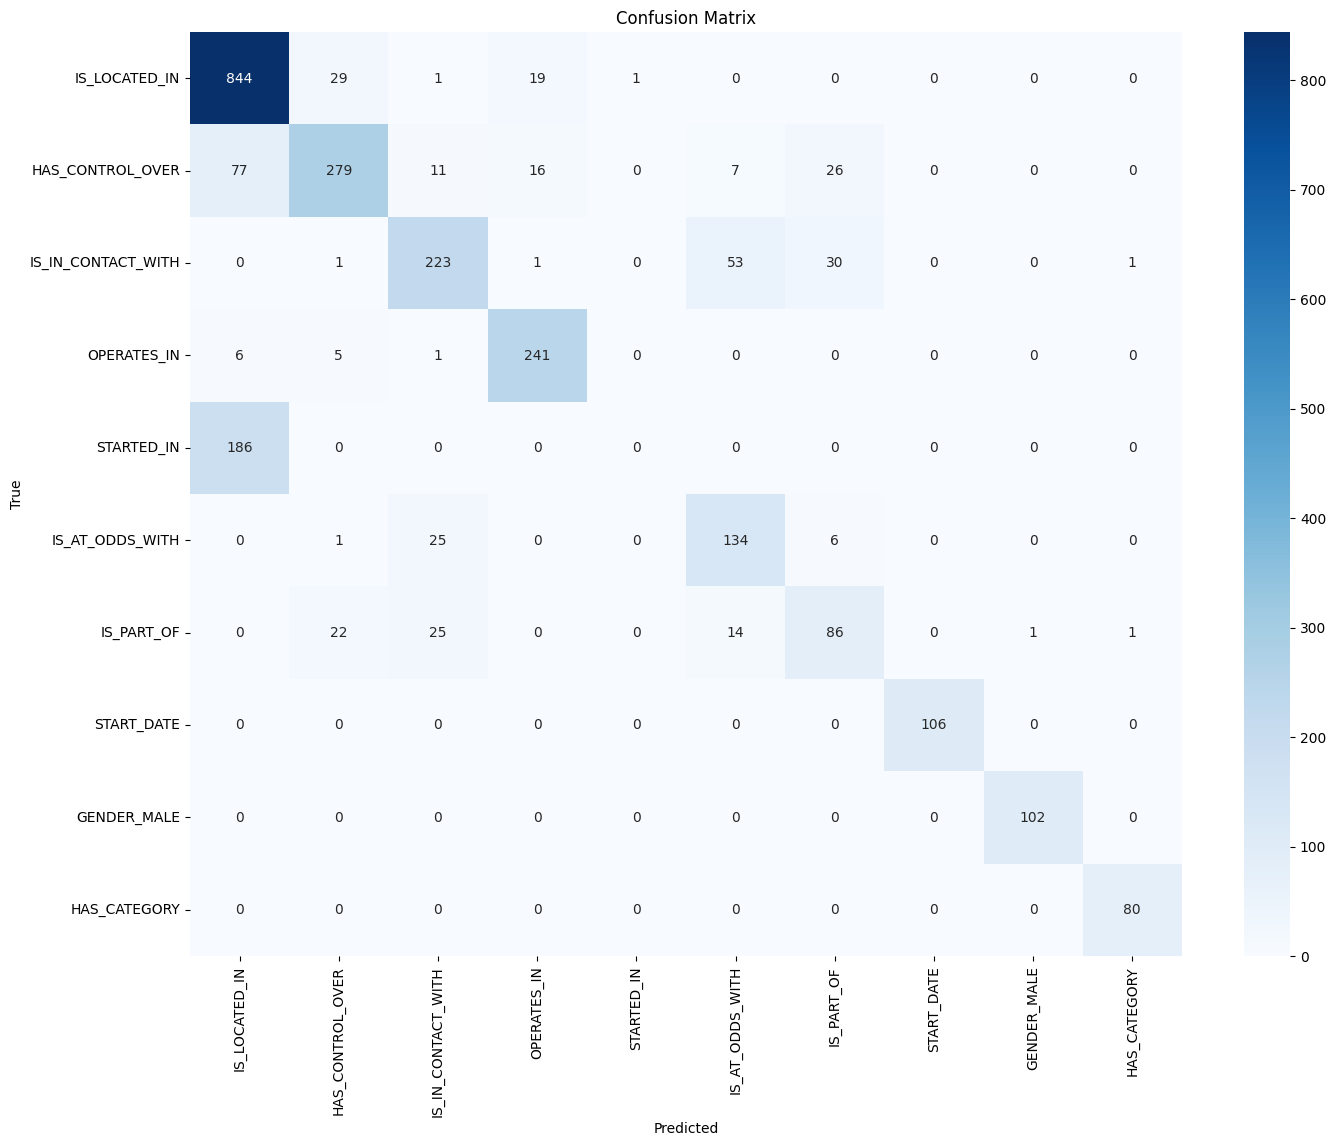

Per-Class Performance Report:
                           Class Precision    Recall  F1-Score  Support
0                  IS_LOCATED_IN  0.758311  0.944072  0.841056      894
1               HAS_CONTROL_OVER  0.827893  0.670673  0.741036      416
2             IS_IN_CONTACT_WITH   0.77972  0.721683  0.749580      309
3                    OPERATES_IN  0.870036  0.952569  0.909434      253
4                     STARTED_IN       0.0       0.0  0.000000      186
5                IS_AT_ODDS_WITH  0.644231  0.807229  0.716578      166
6                     IS_PART_OF  0.581081  0.577181  0.579125      149
7                     START_DATE       1.0       1.0  1.000000      106
8                    GENDER_MALE  0.990291       1.0  0.995122      102
9                   HAS_CATEGORY   0.97561       1.0  0.987654       80
accuracy                       -         -         -  0.787298     2661
macro avg                      -  0.742717  0.767341  0.751958     2661
weighted avg                   -  

In [ ]:
def evaluate_per_class(model, dataloader, relation_types, device='cuda'):
    model = model.to(device)
    model.eval()
    predictions, labels = [], []

    # Process the dataset in batches
    for batch in dataloader:
        inputs = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device),
            'labels': batch['labels'].to(device)
        }
        
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=-1).cpu().numpy())
        labels.extend(inputs['labels'].cpu().numpy())

    # Compute per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        labels, predictions, labels=list(range(len(relation_types))), average=None, zero_division=0
    )
    
    accuracy = accuracy_score(labels, predictions)

    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
        labels, predictions, average='macro', zero_division=0
    )
    weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted', zero_division=0
    )

    report_df = pd.DataFrame({
        'Class': relation_types,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })

    report_df.loc['accuracy'] = ['-', '-', '-', accuracy, np.sum(support)]
    report_df.loc['macro avg'] = ['-', macro_precision, macro_recall, macro_f1, np.sum(support)]
    report_df.loc['weighted avg'] = ['-', weighted_precision, weighted_recall, weighted_f1, np.sum(support)]

    plt.figure(figsize=(16, 12))
    cm = confusion_matrix(labels, predictions, labels=list(range(len(relation_types))))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=relation_types, yticklabels=relation_types)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return report_df

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=data_collator,
)

report_df = evaluate_per_class(model, val_loader, top_10_relations)

print("Per-Class Performance Report:")
print(report_df)

In [18]:
# Save the model
model.save_pretrained("../saved_models/CamRE_nREL10")
tokenizer.save_pretrained("../saved_models/CamRE_nREL10")

('../saved_models/CamRE_nREL10\\tokenizer_config.json',
 '../saved_models/CamRE_nREL10\\special_tokens_map.json',
 '../saved_models/CamRE_nREL10\\sentencepiece.bpe.model',
 '../saved_models/CamRE_nREL10\\added_tokens.json')

Class Weights:
Use class weights in the loss function to penalize misclassifications in minority classes more heavily.

Oversampling/Downsampling:
Oversample minority classes or downsample majority classes during training.

Data Augmentation:
Augment data for minority classes to balance the dataset.

#cross validation?